# Setup

## Colab

In [1]:
# # # Mount the drive and move to dir
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# Switch to current dir
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [7]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os
import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [8]:
# Import the utilities and the dataloader
from utils import trainutil, inferutil, setuputil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)

# Import the funcs needed from utils
from utils.setuputil import setup_config, display_config
from utils.trainutil import train_unified
from utils.inferutil import infer_one, infer_full, binfer_one, binfer_full

## Configuration

In [9]:
# Define the input config file
input_config = {
    # Environment and Model Info
    "env": "colab",
    "approach": "bert",
    "model_name": "CustomSimpleBert",
    "model_base": "bert-base-cased",
    # System Configuration
    "device": "cuda:0",
    "threads": 10,
    "seed": 0,
    # Data Configuration
    "data_dir": "../data",
    "data_ds": "manual",
    # Model Parameters
    "rows": 100,
    "cols": 100,
    "tokens": 16,
    # Training Parameters
    "batch": 16,
    "lr": 1e-3,
    "mu": 0.25,
    "epochs": 3,
    "patience": 2,
    "save_int": 0,
    "save_dir": "../models/",
}
config = setup_config(input_config)
display_config(config)

Processing files: 100%|██████████| 40/40 [00:09<00:00,  4.19it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3655.49it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 2774.38it/s]



5(P) = 5(G) + 0(E)

Configuration for BERT approach:
{
  "env": "colab",
  "approach": "bert",
  "model_base": "bert-base-cased",
  "model_name": "CustomSimpleBert",
  "rows": 100,
  "cols": 100,
  "tokens": 16,
  "DEVICE": "cuda:0",
  "THREADS": 10,
  "seed": 0,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BERT Tokenizer Object>",
  "train_loader": "<LoaderBert Object>",
  "val_loader": "<LoaderBert Object>",
  "test_loader": "<LoaderBert Object>",
  "batch": 16,
  "lr": 0.001,
  "mu": 0.25,
  "epochs": 3,
  "patience": 2,
  "save_int": 0,
  "save_dir": "../models/",
  "save_name": "cber0_CustomSimpleBert_manual_100x100x16_bsz16lr1e-3ep3pa2"
}


In [10]:
# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]
# gber42_TinyBert_manual_100x100x32
# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

# Model Creation

In [11]:
from transformers import BertModel, BertConfig
import torch.nn as nn
import torch
import math
from tqdm import tqdm


class SimpleBertEmbedAvg(nn.Module):
    def __init__(self, dropout_rate=0.05):
        super().__init__()

        # Define params
        self.vocab = 30522
        self.hidden_size = 128
        self.num_hidden_layers = 1
        self.num_attention_heads = 2
        self.intermediate_size = 512
        self.hidden_act = "gelu"
        self.hidden_dropout_prob = dropout_rate
        self.attention_probs_dropout_prob = 0.1
        self.max_position_embeddings = 64
        self.type_vocab_size = 2
        self.layer_norm_eps = 1e-12

        # Setup config with setup vars
        self.config = BertConfig(
            vocab_size=self.vocab,
            hidden_size=self.hidden_size,
            num_hidden_layers=self.num_hidden_layers,
            num_attention_heads=self.num_attention_heads,
            intermediate_size=self.intermediate_size,
            hidden_act=self.hidden_act,
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=self.attention_probs_dropout_prob,
            max_position_embeddings=self.max_position_embeddings,
            type_vocab_size=self.type_vocab_size,
            layer_norm_eps=self.layer_norm_eps
        )

        # Create BERT model from scratch (no pretrained weights)
        self.bert = BertModel(self.config)

        # Simple classification head
        self.dropout = nn.Dropout(dropout_rate)
        self.gelu = nn.GELU()
        self.classifier = nn.Linear(self.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        batch_size, rows, cols, seq_len = input_ids.shape
        S_cube = torch.zeros((batch_size, rows, cols), device=input_ids.device)

        # Process each cell with progress bar
        for cell in range(rows * cols):
            row = cell // cols
            col = cell % cols

            # Simple forward pass
            outputs = self.bert(
                input_ids=input_ids[:, row, col, :],
                attention_mask=attention_mask[:, row, col, :]
            )

            pooled = self.dropout(outputs.pooler_output)
            activated = self.gelu(pooled)
            logits = self.classifier(activated)
            S_cube[:, row, col] = logits.squeeze(-1)

        return S_cube

In [12]:
# 1) Create model and move to GPU Observe its architecture - 440 Mib
untrained_model = SimpleBertEmbedAvg(dropout_rate=0.05).to(DEVICE)
print(untrained_model)

SimpleBertEmbedAvg(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(64, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_af

In [8]:
# # Get a single batch directly from train_loader
# check_loader = torch.utils.data.DataLoader(train_loader, batch_size=1, shuffle=False)
# # Get the first batch
# batch = next(iter(check_loader))

# # Move data to device
# ex_xtok = batch["x_tok"].to(DEVICE)
# ex_xmask = batch["x_masks"].to(DEVICE)

# # Forward pass
# output = untrained_model(input_ids=ex_xtok, attention_mask=ex_xmask)

# print(output.shape)

# Model Training

In [13]:
# Train with adjusted batch size
trained_model = train_unified(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config
)

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.54s/it]


Train Loss: 1.3910173575083415, Perplexity: 1.0000347760386101
Val Loss: 1.3472013473510742, Perplexity: 1.0000336806008625


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.52s/it]


Train Loss: 1.336920698483785, Perplexity: 1.0000334235760173
Val Loss: 1.2371325492858887, Perplexity: 1.0000309287920173


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.46s/it]


Train Loss: 1.1757051547368367, Perplexity: 1.000029393060836
Val Loss: 0.9244929552078247, Perplexity: 1.000023112590972





Filename: ../data/manual_train/portfoliobyloanstatus copy.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(20,0): 0.59855937957763671875
(12,0): 0.59944635629653930664
(16,0): 0.60070842504501342773
(4,4): 0.60091817378997802734
(4,14): 0.60111558437347412109
(32,0): 0.60200703144073486328
(8,0): 0.60268878936767578125
(6,0): 0.60306650400161743164
(24,0): 0.60358715057373046875
(28,0): 0.60514861345291137695
(36,0): 0.63375526666641235352
(8,1): 0.63442248106002807617
(7,1): 0.63598936796188354492
(9,1): 0.63770699501037597656
(4,10): 0.63933950662612915039
(4,12): 0.64060837030410766602
(5,3): 0.64202231168746948242
(0,0): 0.64298766851425170898
(38,0): 0.64426189661026000977
(5,0): 0.64632010459899902344
(37,1): 0.64686691761016845703
(4,6): 0.64699822664260864258
(6,1): 0.64826792478561401367
(4,8): 0.65118873119354248047
(5,2): 0.65183049440383911133
(4,2): 0.66070961952209472656

NB to B ratio: Predicted = 9885:115 | Actual = 9874:126
Accuracy: 99.43% | Precision: 80.00

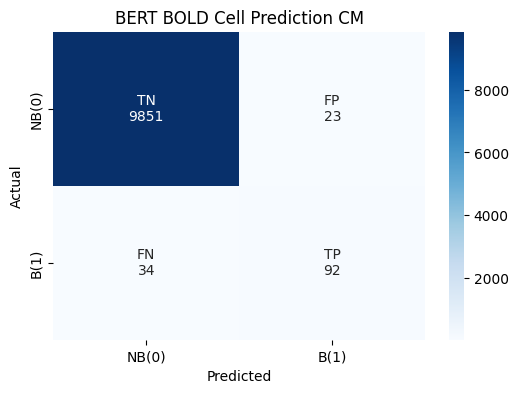


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
from utils import inferutil
importlib.reload(inferutil)
from utils.inferutil import binfer_one

# Params
loc = 0
thresh = 0.63
cond = '>'
disp_max=True

# inference on single position of train loader params
binfer_one(
    trained_model,
    train_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../data/manual_val/ffelbydefermenttype.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(15,0): 0.59855937957763671875
(7,0): 0.59944635629653930664
(11,0): 0.60070842504501342773
(5,14): 0.60111558437347412109
(5,10): 0.60178804397583007812
(27,0): 0.60200703144073486328
(19,0): 0.60358715057373046875
(23,0): 0.60514861345291137695
(5,12): 0.62351757287979125977
(0,0): 0.62546718120574951172
(5,8): 0.63037526607513427734
(5,6): 0.63319128751754760742
(31,0): 0.63375526666641235352
(7,1): 0.63442248106002807617
(10,1): 0.63598936796188354492
(8,1): 0.63770699501037597656
(6,3): 0.64202231168746948242
(5,16): 0.64361876249313354492
(6,0): 0.64632010459899902344
(9,1): 0.64826792478561401367
(5,4): 0.64983075857162475586
(5,2): 0.65158873796463012695
(6,2): 0.65183049440383911133

NB to B ratio: Predicted = 9944:56 | Actual = 9896:104
Accuracy: 99.52% | Precision: 100.00% | Recall: 53.85% | F1-Score: 0.70



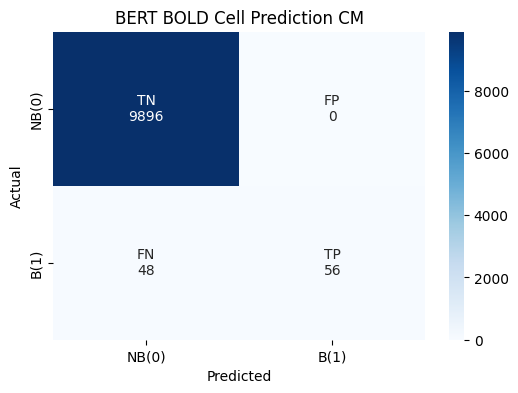


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
5,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
binfer_one(
    trained_model,
    val_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../data/manual_test/dlportfoliobyrepaymentplan.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(21,0): 0.59855937957763671875
(13,0): 0.59944635629653930664
(17,0): 0.60070842504501342773
(5,20): 0.60111558437347412109
(5,18): 0.60191035270690917969
(33,0): 0.60200703144073486328
(9,0): 0.60268878936767578125
(7,0): 0.60306650400161743164
(25,0): 0.60358715057373046875
(29,0): 0.60514861345291137695
(5,16): 0.60640251636505126953
(5,14): 0.62565255165100097656
(5,4): 0.62655818462371826172
(37,0): 0.63375526666641235352
(9,1): 0.63442248106002807617
(8,1): 0.63598936796188354492
(10,1): 0.63770699501037597656
(5,2): 0.63852351903915405273
(5,10): 0.63913798332214355469
(0,0): 0.64139181375503540039
(5,12): 0.64157319068908691406
(6,3): 0.64202231168746948242
(5,8): 0.64339429140090942383
(6,0): 0.64632010459899902344
(7,1): 0.64826792478561401367
(5,6): 0.64853948354721069336
(6,2): 0.65183049440383911133

NB to B ratio: Predicted = 9907:93 | Actual = 9872:128
Accur

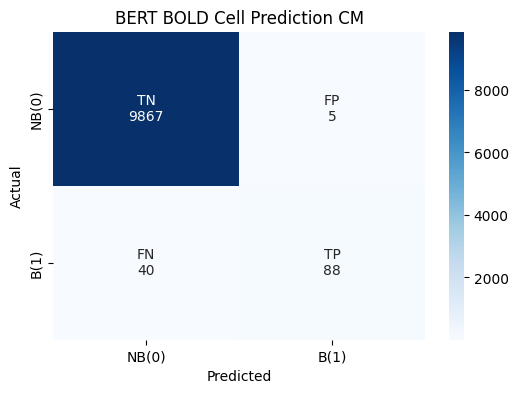


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
binfer_one(
    trained_model,
    test_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)

Batch Inference: 100%|██████████| 3/3 [00:48<00:00, 16.08s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49631:369 | Actual = 49606:394
Accuracy: 99.53% | Precision: 73.76% | Recall: 71.78% | F1-Score: 0.71



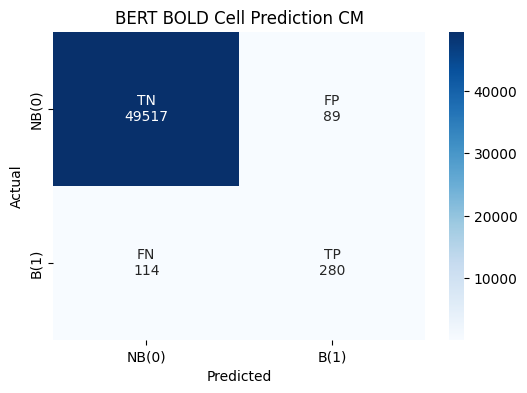

In [20]:
binfer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=2,
    threshold=thresh,
    device=DEVICE
)

Batch Inference: 100%|██████████| 1/1 [00:16<00:00, 16.32s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49600:400 | Actual = 49602:398
Accuracy: 99.53% | Precision: 70.50% | Recall: 70.85% | F1-Score: 0.71



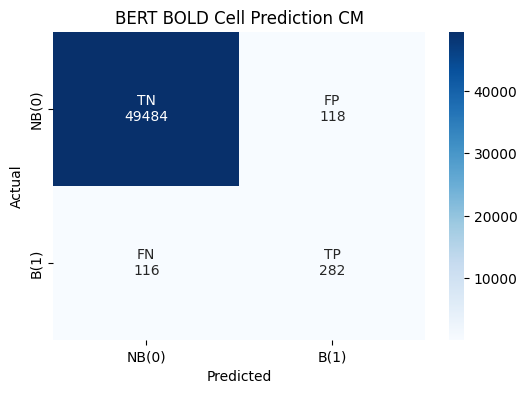

In [21]:
binfer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=6,
    threshold=thresh,
    device=DEVICE
)

Batch Inference: 100%|██████████| 4/4 [01:04<00:00, 16.22s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 396584:3416 | Actual = 396714:3286
Accuracy: 99.55% | Precision: 74.94% | Recall: 74.47% | F1-Score: 0.73



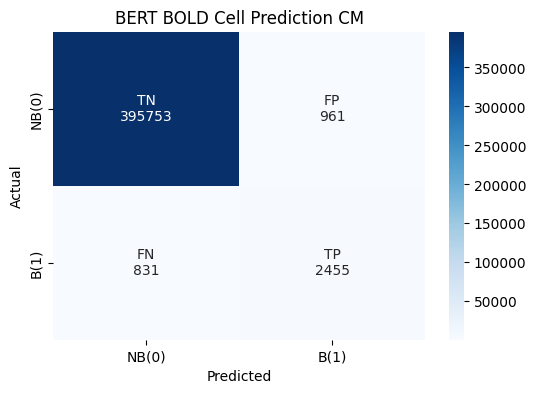

In [22]:
binfer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=10,
    threshold=thresh,
    device=DEVICE
)